In [50]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

import torch
import evaluate
from transformers import BertForSequenceClassification, PreTrainedTokenizerFast, AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.metrics import roc_curve, roc_auc_score

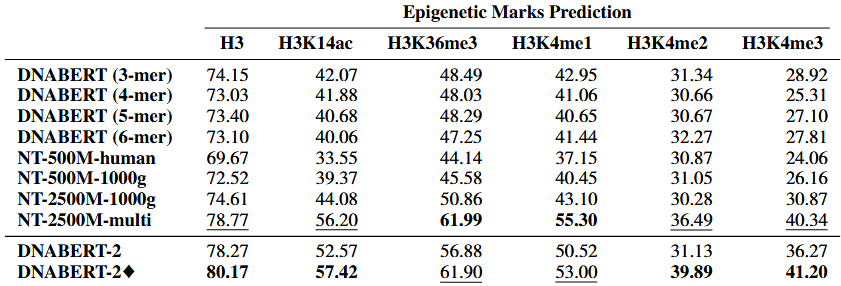

In [65]:
def get_auc(data_path, output_dir = ""): 

    # Load data
    data = pd.read_csv(data_path)
    labels = list(data['label'])  # Your true labels (binary in this case)
    sequences = list(data['sequence'])  # Your text data
    
    # Load model and tokenizer
    if output_dir:
        model = AutoModelForSequenceClassification.from_pretrained(output_dir, trust_remote_code=True)
        tokenizer = AutoTokenizer.from_pretrained(output_dir, trust_remote_code=True)
    else:
        model = AutoModelForSequenceClassification.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
        tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
    
    # Tokenize texts and convert to tensors
    input = tokenizer(sequences, padding="longest", truncation=True, return_tensors='pt', max_length=tokenizer.model_max_length)

    # Forward pass to get predictions
    with torch.no_grad(): # Disabling gradient calculation, useful for inference
        output = model(**input)
        logits = output.logits
    
    # Get predicted probabilities
    predicted_probabilities = torch.softmax(logits, dim=1)
    predicted_probabilities = predicted_probabilities[:, 1].numpy()  # Assuming it's a binary classification task

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, predicted_probabilities)
    auc = roc_auc_score(labels, predicted_probabilities)

    return fpr, tpr, auc

In [59]:
h3 = get_auc("./results/h3/model_data/test.csv","./results/h3/output/checkpoint-1800/")
f14 = get_auc("./results/gnra_f14_r80_m3/model_data/test.csv","./results/gnra_f14_r80_m3/output/checkpoint-1600/")
f8 = get_auc("./results/gnra_f8_m2_r80/model_data/test.csv","./results/gnra_f8_m2_r80/output/checkpoint-600/")

You are using a model of type bert to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
C:\Users\Xinhe/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\dd10f74f0e90735d02a27603e56467761893e8f9\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
You are using a model of type bert to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
C:\Users\Xinhe/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\dd10f74f0e90735d02a27603e56467761893e8f9\bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
You are using a model of type bert to instantiate a model of type . This is no

In [ ]:
f14_best_fine = get_auc("./results/gnra_f14_r80_m3/model_data/test.csv","./results/gnra_f14_r80_m3/output/checkpoint-1600/")
f14_best_base = get_auc("./results/gnra_f14_r80_m3/model_data/test.csv")
# f14_bad_fine = get_auc("./results/gnra_f14_r80_m3_2/model_data/test.csv","./results/gnra_f14_r80_m3_2/output/checkpoint-1800/")
# f14_bad_base = get_auc("./results/gnra_f14_r80_m3_2/model_data/test.csv")
# f8_fine = get_auc("./results/gnra_f8_m2_r80/model_data/test.csv","./results/gnra_f8_m2_r80/output/checkpoint-600/")
# f8_base = get_auc("./results/gnra_f8_m2_r80/model_data/test.csv")
# h3_fine = get_auc("./results/h3/model_data/test.csv","./results/h3/output/checkpoint-1800/")

In [70]:
# Plot ROC curve
def plot_ROC_curve(series):
    plt.figure(figsize=(8, 6))

    for i in series:
        metrics, name = i[0], i[1]
        plt.plot(metrics[0], metrics[1], label=f'{name} (AUC = {metrics[2]:.2f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend()
    plt.grid()
    plt.show()

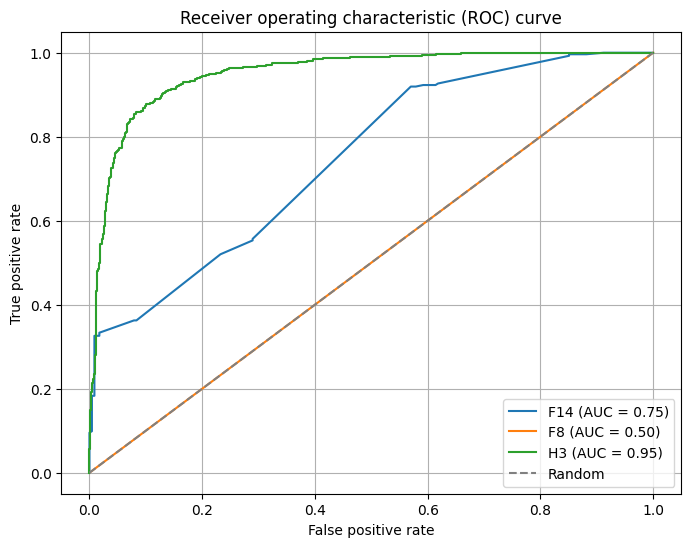

In [71]:
plot_ROC_curve([(f14, "F14"), (f8, "F8"), (h3, "H3")])

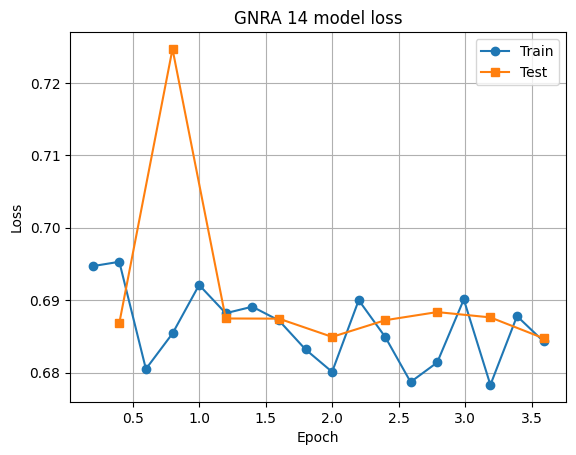

In [7]:
# Loss

file_path = "./results/gnra_f14_r80_m3_2/output/checkpoint-1800/trainer_state.json"
with open(file_path, 'r') as file:
    data = json.load(file)
log = data["log_history"]

train_entries = [i for i in log if "loss" in i.keys()]
train_epochs = [i["epoch"] for i in train_entries]
train_loss = [i["loss"] for i in train_entries]

eval_entries = [i for i in log if "eval_loss" in i.keys()]
eval_epochs = [i["epoch"] for i in eval_entries]
eval_loss = [i["eval_loss"] for i in eval_entries]

plt.plot(train_epochs, train_loss, marker='o')
plt.plot(eval_epochs, eval_loss, marker='s')
plt.title("GNRA 14 model loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Train","Test"])
plt.grid()
plt.show()